In [266]:
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats import chi2_contingency

### Cleaning

In [267]:
#read csv into df to clean
filepath = Path("mental-heath-in-tech-2016_20161114.csv")

original_csv_df = pd.read_csv(filepath, sep=',', index_col='Index')
original_csv_df.head(5)

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",...,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What country do you live in?,What US state or territory do you live in?,What country do you work in?,What US state or territory do you work in?,Which of the following best describes your work position?,Do you work remotely?
Index,,,,,,,,,,,,,,,,,,,,,
1,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,...,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
2,0,45102,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,...,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
3,0,45102,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,...,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Sometimes,Sometimes,43,male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes
5,0,45102,0.0,1.0,Yes,Yes,No,No,No,Neither easy nor difficult,...,Sometimes,Sometimes,43,Female,United States of America,Illinois,United States of America,Illinois,Executive Leadership|Supervisor/Team Lead|Dev ...,Sometimes


In [268]:
#remove all cols except Index, Does employer provide MH benefits?, Have you had a MH disorder in the past?, Do you currently have a MH disorder?
kept_columns = ['Does your employer provide mental health benefits as part of healthcare coverage?',
                'Have you had a mental health disorder in the past?',
                'Do you currently have a mental health disorder?']

#create new df with remaining cols
cleaned_df_q3a = original_csv_df[kept_columns]
cleaned_df_q3a.head()

,Does your employer provide mental health benefits as part of healthcare coverage?,Have you had a mental health disorder in the past?,Do you currently have a mental health disorder?
Index,,,
1,Not eligible for coverage / N/A,Yes,No
2,No,Yes,Yes
3,No,Maybe,No
4,NaN,Yes,Yes
5,Yes,Yes,Yes


In [269]:
#remove rows with "i dont know", "Not eligible for benefits/ N/A", NaN across all columns - not useful for answering the question
responses_to_remove = ["Not eligible for coverage / N/A", "I don't know", "NaN", np.nan]
cleaned_df_q3a = cleaned_df_q3a[~cleaned_df_q3a.isin(responses_to_remove).any(axis=1)]
#kept "Maybe" responses in last 2 columns because removing would leave us with less than 1/3 of original data 
#555 responses left after cleaning (roughly 40% of dataset)
cleaned_df_q3a.head()

,Does your employer provide mental health benefits as part of healthcare coverage?,Have you had a mental health disorder in the past?,Do you currently have a mental health disorder?
Index,,,
2,No,Yes,Yes
3,No,Maybe,No
5,Yes,Yes,Yes
6,Yes,No,Yes
8,Yes,Yes,Yes


In [270]:
#create new col for mental health outcomes
#approach for establishing mental health outcome: -1 = negative, 0 = no change/uncertain, 1 = positive
#there are many limitations to our dataset, this approach seems to be the most reasonable given available data
#using -1, 0, +1 allows us to roughly quantify the difference between Past/ Present mental health states, which would indicate change over time (improvement/worsening)
#we are assuming that everyone who has a mental health disorder seeks resources/ help for it. In real life, this is often not the case
#the dimensionality of the responses has been greatly reduced- "yes/no/maybe" does not accurately reflect the broad spectrum of severity of mental health disorders
#one way to improve the dataset would be to have respondents specifiy how long ago their past mental health problem began/occured, and when the current one began/ was diagnosed

cleaned_df_q3a["Mental Health Outcome"] = cleaned_df_q3a.apply(
    lambda row: 0 if row["Have you had a mental health disorder in the past?"] == row["Do you currently have a mental health disorder?"] == "Maybe"
    else -1 if row["Have you had a mental health disorder in the past?"] == row["Do you currently have a mental health disorder?"] == "Yes"
    else -1 if row["Have you had a mental health disorder in the past?"] == "No" and row["Do you currently have a mental health disorder?"] == "Yes"
    else 1 if row["Have you had a mental health disorder in the past?"] == "Yes" and row["Do you currently have a mental health disorder?"] == "No"
    else 0, axis=1)
cleaned_df_q3a.head()

,Does your employer provide mental health benefits as part of healthcare coverage?,Have you had a mental health disorder in the past?,Do you currently have a mental health disorder?,Mental Health Outcome
Index,,,,
2,No,Yes,Yes,-1
3,No,Maybe,No,0
5,Yes,Yes,Yes,-1
6,Yes,No,Yes,-1
8,Yes,Yes,Yes,-1


## Q3.a: Analysis & Visualizations

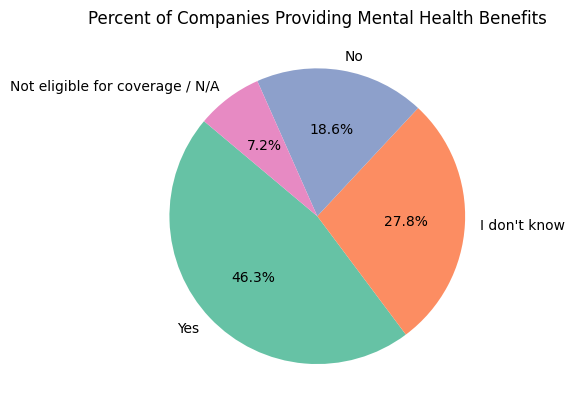

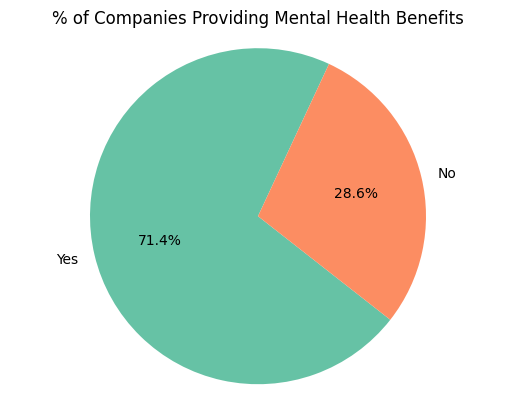

In [271]:
#visualize how many companiies provide mental health benefits
benefits_count = original_csv_df["Does your employer provide mental health benefits as part of healthcare coverage?"].value_counts()
labels = benefits_count.index
sizes = benefits_count.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Percent of Companies Providing Mental Health Benefits")
plt.show()

#visualize only yes/no responses about how many companiies provide mental health benefits (removed N/A and IDK responses)
benefits_count = cleaned_df_q3a["Does your employer provide mental health benefits as part of healthcare coverage?"].value_counts()
labels = benefits_count.index
sizes = benefits_count.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=65)
plt.axis('equal')
plt.title("% of Companies Providing Mental Health Benefits")
plt.show()

<Figure size 600x400 with 0 Axes>

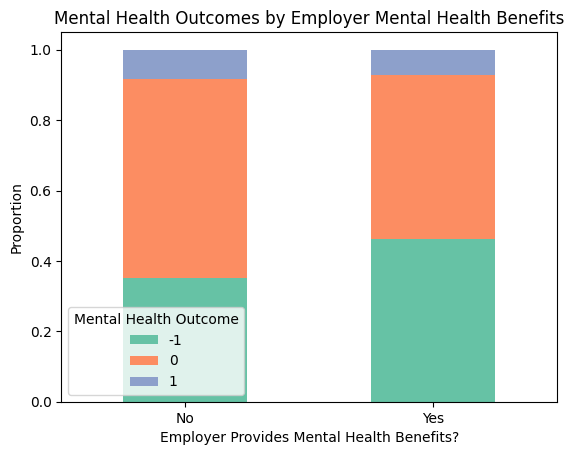

Mental Health Outcome,-1,0,1
Does your employer provide mental health benefits as part of healthcare coverage?,,,
No,0.352,0.563,0.085
Yes,0.463,0.465,0.072


In [272]:
#create df with proportion data for plotting
value_counts_df = cleaned_df_q3a.groupby("Does your employer provide mental health benefits as part of healthcare coverage?")["Mental Health Outcome"].value_counts(normalize=True).unstack()

#visualize how proportions of pos/neg/nochg outcomes differ at companies that offer MH benefits vs those that dont
sns.set_palette("Set2")
plt.figure(figsize=(6, 4))
value_counts_df.plot(kind="bar", stacked=True)
plt.xlabel("Employer Provides Mental Health Benefits?")
plt.ylabel("Proportion")
plt.title("Mental Health Outcomes by Employer Mental Health Benefits")
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.show()
#show df with proportions
value_counts_df.round(3)

In [273]:
#run a chi-squared test on data
# Create a contingency table for the chi-squared test
contingency_table = pd.crosstab(cleaned_df_q3a["Does your employer provide mental health benefits as part of healthcare coverage?"], cleaned_df_q3a["Mental Health Outcome"])

chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-Squared Value:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)

Chi-Squared Value: 7.665596250244149
P-value: 0.021648954317514096
Degrees of Freedom: 2
Expected Frequencies:
[[ 91.89919355 105.06854839  16.03225806]
 [229.10080645 261.93145161  39.96774194]]


The p-value (0.007583566185248004) is below the significance level of 0.05, meaning that we can reject the null hypothesis. In other words, there is a statistically significant association between employer-provided mental health benefits and mental health outcomes, and it is unlikely to have occurred by random chance.

the chi-squared test indicates that companies providing mental health resources have more negative mental health outcomes, which seems counterintuitive.

Several possible explanations for this contradictory result:
- It's possible that companies providing mental health resources are already aware of a higher prevalence of mental health issues among their employees and are therefore offering more resources as a "proactive" response.
- Sampling bias: The dataset is likely not representative of the entire population.
- Measurement error: The method used for measuring mental health outcomes could be causing our inaccurate results because it makes many assumptions about the data. 
- Confounding variables: There could be other variables influencing the relationship between mental health resources and mental health outcomes that aren't accounted for in the dataset. A few examples include company culture, work environment, management support, and external stressors that might influence mental health outcomes and whether companies offer mental health resources. 
- Random chance: there's always a possibility that the observed pattern is due to random chance

To improve future surveys, we can ask respondents if they have had mental health problems within the past year (rather than over their entire life, which is far more likely)